In [9]:
setwd('/import/liujing/data/my')

In [10]:
load('../expr2.test.rda')

In [11]:
diff = read.table('../diffgeen.txt',header =T,sep = '\t',check.names =  F)

In [12]:
colnames(diff) = 'genename'

In [13]:
library(dplyr)

In [14]:
expr = data1[,diff$genename]

In [15]:
colnames(expr) = gsub('-','.',colnames(expr))

In [16]:
head(expr,2)

,RAB7A,CEACAM1,CMTM1,RASD2,PLP2,RPL28,MANSC1,SLC26A8,OTX1,NEK2,...,HIST1H2BM,HIST1H3C,HCAR1,PDCD1LG2,F5,HSPA1A,RPS28,KIAA0040,MIF,IL10RB
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10,106.76150,11.929714,62.24463,0.00000000,56.63791,113.3972,18.572959,0.9184147,0.6572815,0.02057717,...,7.820801,11.80605,0.4341454,0.1803183,14.810370,36.99336,189.35981,49.03202,1.404127,38.81624
CI11,72.15124,5.991606,32.25547,0.01869048,58.63627,171.8261,6.043225,1.4157453,0.2111216,0.37921862,...,30.742074,50.15614,0.6275221,0.6857197,7.715352,14.12785,14.20498,43.80901,4.025280,29.94399


In [17]:
Type = c(rep(1,16),rep(0,18))

In [18]:
Type

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [56]:
x = as.matrix(expr)
y = Type

In [57]:
library(randomForest)

In [58]:
options(repr.plot.width = 6)

In [59]:
set.seed(1)

In [60]:
rf = randomForest(as.factor(y)~.,data = x,ntree =1000,important=TRUE,proximity=TRUE)

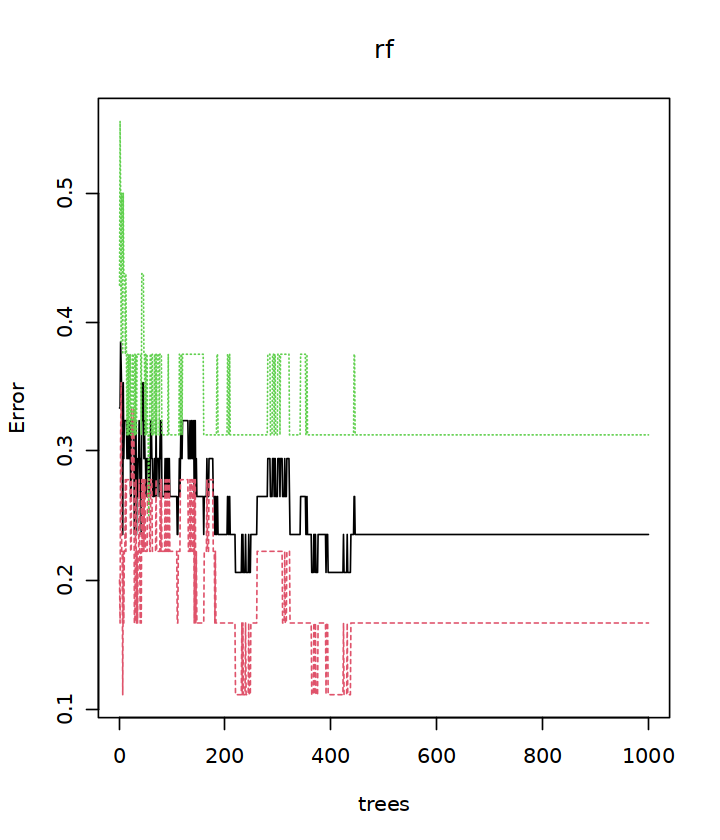

In [61]:
plot(rf)

In [62]:
pdf('forest.pdf',height = 6,width = 6)
plot(rf)
dev.off()

png 
  2

In [63]:
trees = which.min(rf$err.rate[,1])

In [64]:
rf = randomForest(as.factor(y)~.,data = x,ntree =trees,important=TRUE,proximity=TRUE)

In [65]:
importance = importance(rf)

In [66]:
pdf('forest2.pdf',height = 6,width = 4)
varImpPlot(rf,main = '')
dev.off()

png 
  2

In [67]:
# RPE65 + MC3R+NFIL3 + PRF1 + IL6

In [68]:
options(repr.plot.width = 4)

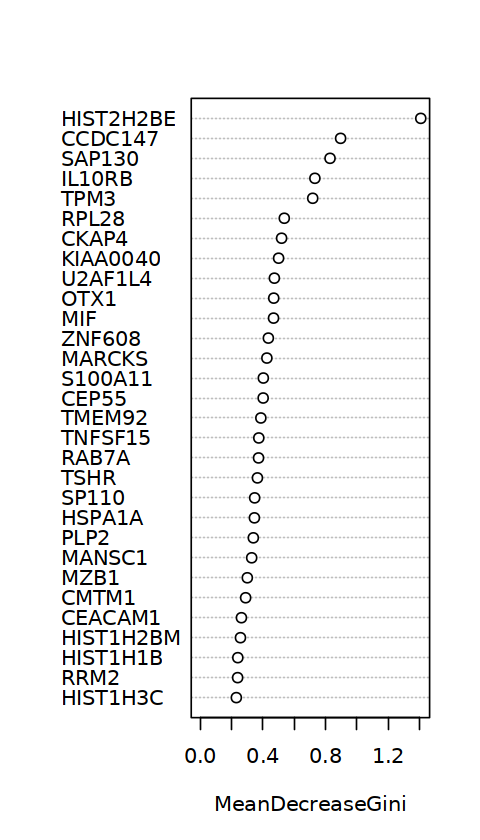

In [69]:
varImpPlot(rf,main = '')

In [70]:
rfGenes=importance[order(importance[, "MeanDecreaseGini"], decreasing  = TRUE),] #重要性评分大于2的基因

In [71]:
rfGenes

HIST2H2BE    CCDC147     SAP130     IL10RB       TPM3      RPL28      CKAP4 
1.40816298 0.89672338 0.82927587 0.73255180 0.71874567 0.53737249 0.52019843 
  KIAA0040    U2AF1L4       OTX1        MIF     ZNF608     MARCKS    S100A11 
0.50111928 0.47405660 0.47002741 0.46885880 0.43572943 0.42626504 0.40362421 
     CEP55     TMEM92    TNFSF15      RAB7A       TSHR      SP110     HSPA1A 
0.40263231 0.38784991 0.37468268 0.37318077 0.36603852 0.34831902 0.34671431 
      PLP2     MANSC1       MZB1      CMTM1    CEACAM1  HIST1H2BM   HIST1H1B 
0.33981439 0.32932373 0.30148668 0.29081236 0.26387419 0.25776815 0.24083296 
      RRM2   HIST1H3C      CCNA2      HCAR1         F5       NEK2       TLR5 
0.23975167 0.23145691 0.22612451 0.20869076 0.18909271 0.18658156 0.18260181 
     GPR84      PRRG4    TNFSF14      PARM1    SLC26A8       BUB1     PNPLA1 
0.17566397 0.17228238 0.17133801 0.15996207 0.15833314 0.14151677 0.12538153 
  PDCD1LG2      HJURP      RPS28      SGOL1      RASD2 
0.12512350 0.12481478 0.11997995 0.09197387 0.02863636

In [72]:
rfGenes=names(rfGenes[rfGenes>30]) 
write.table(rfGenes,file="rfGenes.txt",sep="\t",quote=F,col.names=F,row.names=F) #输出表达量

In [73]:
sigExp=expr[rfGenes,]
write.table(data.frame(ID=rownames(sigExp),sigExp),file="rfGeneExp.txt",sep="\t",quote=F,col.names=T,row.names=F) 

### svm

In [74]:
library(tidyverse)
library(glmnet)
library(VennDiagram)
library(e1071)
library(caret)
library(randomForest)

In [75]:
y=as.numeric(as.factor(Type))

In [76]:
library(future)
plan("multisession",workers=30)

In [77]:
set.seed(1)
rfeControl = rfeControl(functions = caretFuncs,
                        method = "cv", # 默认自助法重采样 boot
                        saveDetails = T, # 保存预测值和变量重要性
                        number = 5, # 重抽样次数
                        allowParallel = T # 允许多线程，用这个之前你要先准备好多线程！
                        )

In [78]:
Profile=rfe(x=x,y=y,sizes = c(1:10),
    rfeControl =  rfeControl,
    methods="svmRadial")

Warning message in train.default(x, y, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

In [79]:
pdf(file="SVM-RFE.pdf", width=6, height=5.5)
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)
dev.off()

png 
  2

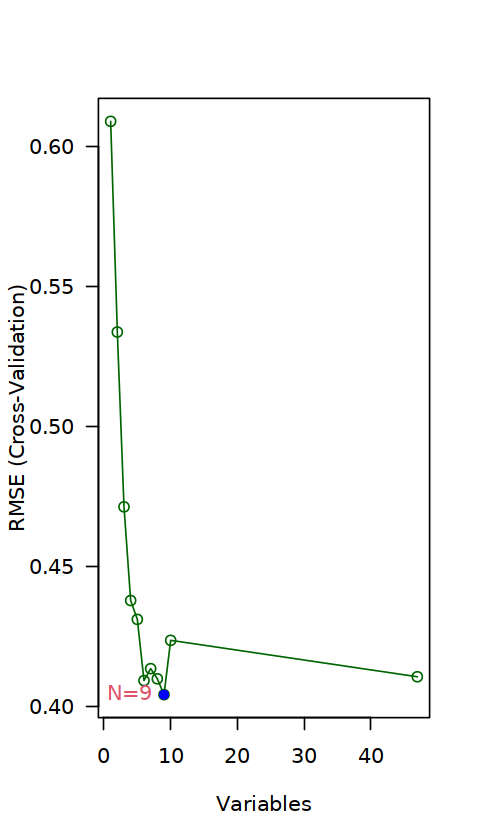

In [80]:
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)

In [81]:
#输出
featureGenes = Profile$optVariables
write.table(file="SVM-RFE.gene.txt",featureGenes,sep="\t",quote=F,row.names=F,col.names=F) #表达矩阵 

In [82]:
featureGenes

[1] "SAP130"    "HIST2H2BE" "CKAP4"     "PLP2"      "KIAA0040"  "CCDC147"  
[7] "IL10RB"    "HSPA1A"    "MARCKS"

### Boruta

In [83]:
library(Boruta)

In [84]:
x = as.matrix(expr)
y = Type

In [85]:
set.seed(1)
boruta <- Boruta(x=x, y=y, pValue=0.05, mcAdj=T, 
       maxRuns=300)

In [86]:
boruta

Boruta performed 299 iterations in 17.05163 secs.
 11 attributes confirmed important: CCDC147, CMTM1, HIST2H2BE, IL10RB,
KIAA0040 and 6 more;
 33 attributes confirmed unimportant: BUB1, CCNA2, CEP55, CKAP4, F5 and
28 more;
 3 tentative attributes left: CEACAM1, MARCKS, PLP2;

In [87]:
table(boruta$finalDecision)


Tentative Confirmed  Rejected 
        3        11        33 

In [88]:
boruta$finalDecision

RAB7A   CEACAM1     CMTM1     RASD2      PLP2     RPL28    MANSC1   SLC26A8 
 Rejected Tentative Confirmed  Rejected Tentative Confirmed  Rejected  Rejected 
     OTX1      NEK2   CCDC147     HJURP   TNFSF14     SGOL1     PRRG4     SP110 
 Rejected  Rejected Confirmed  Rejected  Rejected  Rejected  Rejected  Rejected 
    CKAP4    SAP130     CEP55     GPR84      TPM3     CCNA2    MARCKS   U2AF1L4 
 Rejected Confirmed  Rejected  Rejected Confirmed  Rejected Tentative Confirmed 
  S100A11      TSHR    TMEM92    ZNF608     PARM1      BUB1      MZB1      RRM2 
 Rejected  Rejected  Rejected Confirmed  Rejected  Rejected  Rejected  Rejected 
   PNPLA1   TNFSF15  HIST1H1B HIST2H2BE      TLR5 HIST1H2BM  HIST1H3C     HCAR1 
 Rejected  Rejected  Rejected Confirmed  Rejected  Rejected  Rejected  Rejected 
 PDCD1LG2        F5    HSPA1A     RPS28  KIAA0040       MIF    IL10RB 
 Rejected  Rejected  Rejected  Rejected Confirmed Confirmed Confirmed 
Levels: Tentative Confirmed Rejected

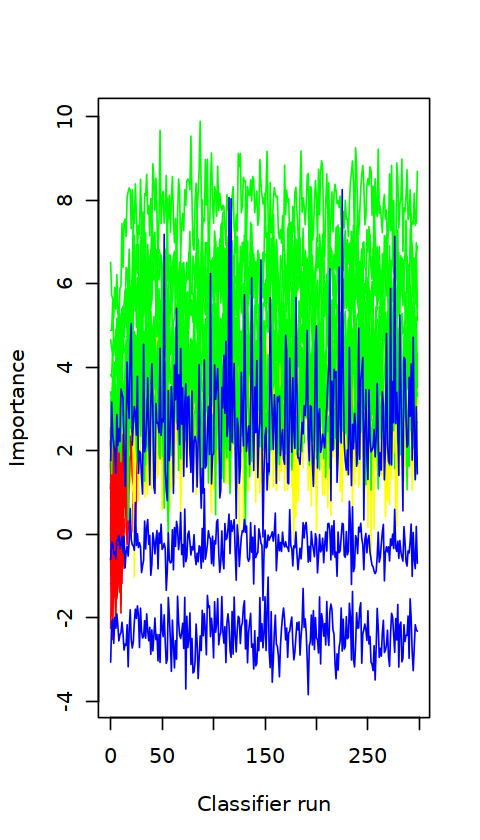

In [89]:
Boruta::plotImpHistory(boruta)

In [90]:
library(dplyr)
boruta.imp <- function(x){
  imp <- reshape2::melt(x$ImpHistory, na.rm=T)[,-1]
  colnames(imp) <- c("Variable","Importance")
  imp <- imp[is.finite(imp$Importance),]

  variableGrp <- data.frame(Variable=names(x$finalDecision), 
                            finalDecision=x$finalDecision)

  showGrp <- data.frame(Variable=c("shadowMax", "shadowMean", "shadowMin"),
                        finalDecision=c("shadowMax", "shadowMean", "shadowMin"))

  variableGrp <- rbind(variableGrp, showGrp)

  boruta.variable.imp <- merge(imp, variableGrp, all.x=T)

  sortedVariable <- boruta.variable.imp %>% group_by(Variable) %>% 
    summarise(median=median(Importance)) %>% arrange(median)
  sortedVariable <- as.vector(sortedVariable$Variable)


  boruta.variable.imp$Variable <- factor(boruta.variable.imp$Variable, levels=sortedVariable)

  invisible(boruta.variable.imp)
}
boruta.variable.imp <- boruta.imp(boruta)


Welcome to YSX package which is a collection of useful scripts.
This package does not require you install all depended packages, since one may not need all functions in this package.
However, when there is a message implying some functions are missing,please install these packages manually.
Or more specially, check Plot.Rmd in vignettes first.




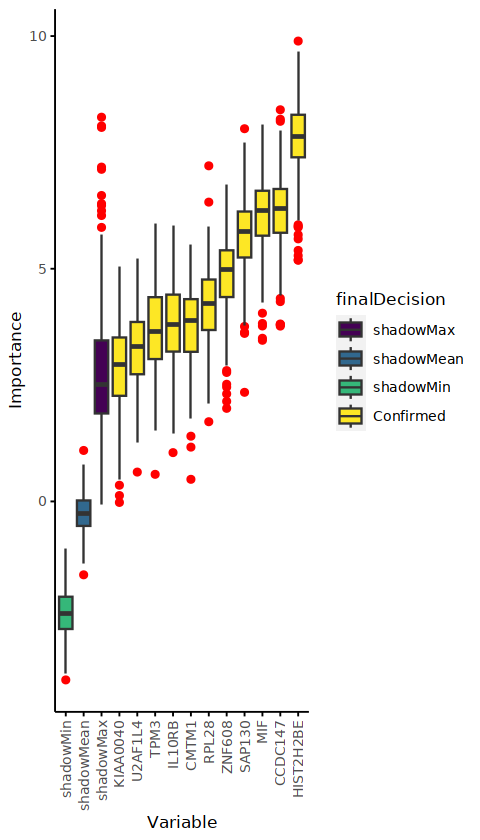

In [91]:
library(YSX)

sp_boxplot(boruta.variable.imp, melted=T, xvariable = "Variable", yvariable = "Importance",
           legend_variable = "finalDecision", legend_variable_order = c("shadowMax", "shadowMean", "shadowMin", "Confirmed"),
           xtics_angle = 90)

In [94]:
Group = data.frame(Group =  c(rep('CI',16),rep('H',18)))

In [95]:
expr3 = cbind(Group,expr)

In [96]:
set.seed(157)  
index <-  which( (1:nrow(expr3))%%3 == 0 )
train <- expr3[-index,]
test <- expr3[index,]

In [97]:
table(test$Group)


CI  H 
 5  6 

In [98]:
library("xgboost")
library("Matrix")
train_matrix <- sparse.model.matrix(Group ~ .-1, data = train)
test_matrix <- sparse.model.matrix(Group ~ .-1, data = test)
all_matrix <- sparse.model.matrix(Group ~ .-1, data = expr3)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [99]:
train_label <- as.numeric(train$Group == 'CI')
test_label <-  as.numeric(test$Group == 'CI')
all_label <-  as.numeric(expr3$Group == 'CI')

In [100]:
all_label

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [101]:
train_fin <- list(data=train_matrix,label=train_label) 
test_fin <- list(data=test_matrix,label=test_label) 
all_fin <- list(data=all_matrix,label=all_label) 

dtrain <- xgb.DMatrix(data = train_fin$data, label = train_fin$label) 
dtest <- xgb.DMatrix(data = test_fin$data, label = test_fin$label)
dall <- xgb.DMatrix(data = all_fin$data, label = all_fin$label)

In [102]:
xgb <- xgboost(data = dall,max_depth=6, eta=0.5,  
  objective='binary:logistic', nround=25)

[1]	train-logloss:0.453170 
[2]	train-logloss:0.335985 
[3]	train-logloss:0.233056 
[4]	train-logloss:0.182805 
[5]	train-logloss:0.154786 
[6]	train-logloss:0.127524 
[7]	train-logloss:0.116528 
[8]	train-logloss:0.108257 
[9]	train-logloss:0.100723 
[10]	train-logloss:0.093924 
[11]	train-logloss:0.089382 
[12]	train-logloss:0.084669 
[13]	train-logloss:0.079859 
[14]	train-logloss:0.076053 
[15]	train-logloss:0.072970 
[16]	train-logloss:0.070234 
[17]	train-logloss:0.068858 
[18]	train-logloss:0.068855 
[19]	train-logloss:0.068854 
[20]	train-logloss:0.068854 
[21]	train-logloss:0.068854 
[22]	train-logloss:0.068854 
[23]	train-logloss:0.068854 
[24]	train-logloss:0.068854 
[25]	train-logloss:0.068854 


In [103]:
xgb

##### xgb.Booster
raw: 22.6 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max_depth = 6, eta = 0.5, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "6", eta = "0.5", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 47 
niter: 25
nfeatures : 47 
evaluation_log:
    iter train_logloss
       1    0.45316981
       2    0.33598455
---                   
      24    0.06885365
      25    0.06885363

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
HIST2H2BE,0.37055212,0.18945456,0.12
CCDC147,0.12629465,0.15222035,0.16
CEP55,0.11087530,0.06163243,0.04
RPL28,0.08847350,0.04901739,0.04
SAP130,0.05870439,0.08511521,0.08
U2AF1L4,0.05466939,0.12629552,0.16


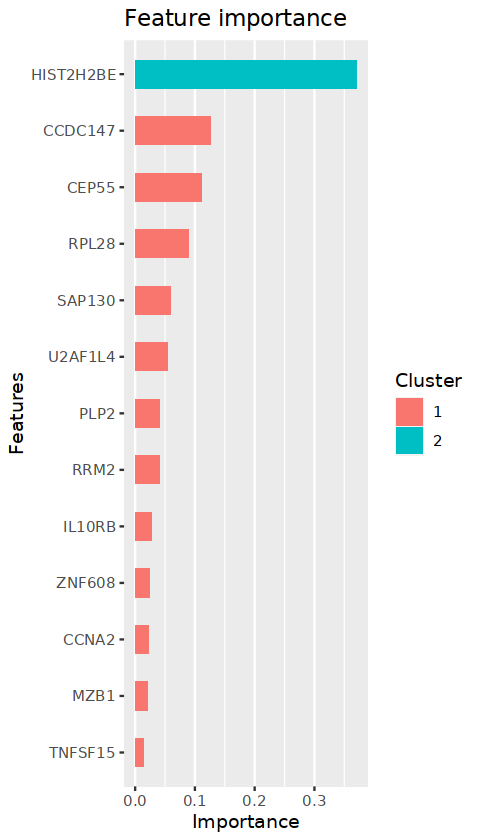

In [104]:
importance <- xgb.importance(all_matrix@Dimnames[[2]], model = xgb)  
head(importance)
xgb.ggplot.importance(importance)

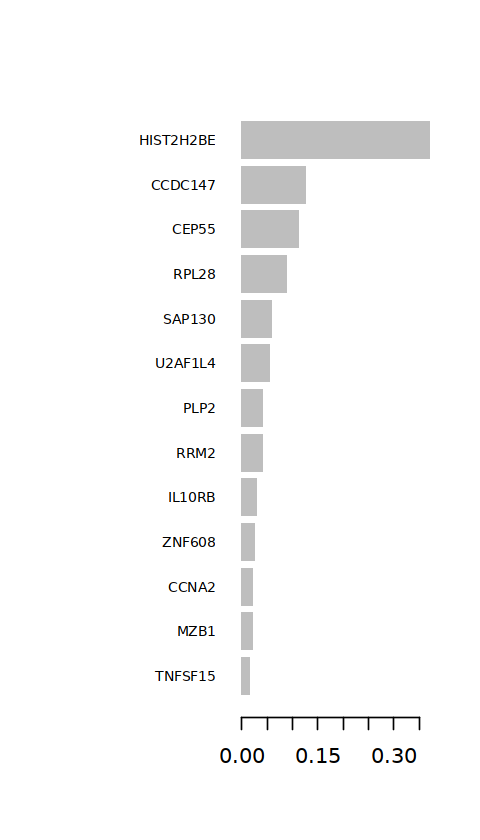

In [105]:
xgb.plot.importance(importance)

### 韦恩图

In [234]:
RF.gene = colnames(sigExp)
SVF.RFE.gene = featureGenes
XGBoost.gene = importance$Feature

In [235]:
boruta.variable.imp2 = boruta.variable.imp %>% dplyr::filter(finalDecision %in% c('Confirmed')) %>% dplyr::select(Variable) %>% unique()

In [236]:
Boruta.gene = as.vector(boruta.variable.imp2$Variable)

In [237]:
list1 = list(Boruta.gene,SVF.RFE.gene, RF.gene,XGBoost.gene) #

In [238]:
data =  as.data.frame (do.call (cbind, list1))

Warning message in (function (..., deparse.level = 1) :
"number of rows of result is not a multiple of vector length (arg 1)"


In [239]:

library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

    if (ncol(data) == 2){
        sample_list <- list(Boruta.gene = data[,1], XGBoost.gene = data[,2])
    }else if(ncol(data) == 3){
        sample_list <- list(RF.gene = data[,1], Boruta.gene = data[,2], XGBoost.gene = data[,3])
    }else if(ncol(data) == 4){
        sample_list <- list(RF.gene = data[,1], SVF.RFE.gene = data[,2], Boruta.gene = data[,3], XGBoost.gene = data[,4])
    }else{
        sample_list <- list(c1 = data[,1], c2 = data[,2], c3 = data[,3], c4 = data[,4], c5 = data[,5])
    }
    
    q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', ncol(data)), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

png 
  2

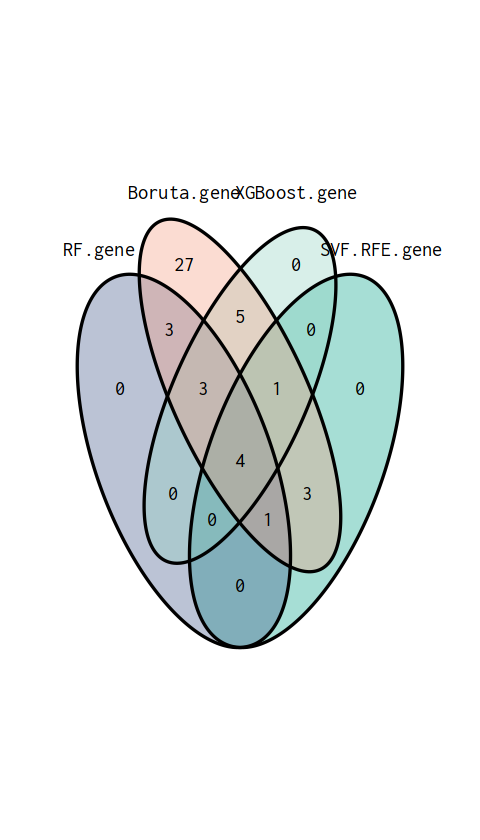

In [240]:
grid.draw(q)

In [241]:
model.gene = intersect(intersect(intersect(RF.gene,XGBoost.gene),Boruta.gene),SVF.RFE.gene)#

In [242]:
model.gene

[1] "CCDC147"   "SAP130"    "HIST2H2BE" "IL10RB"

In [243]:
set.seed(1234)

In [244]:
expr3 = cbind(Group,expr)

In [245]:
expr3[expr3$Group =='CI',]$Group<-1

In [246]:

expr3[expr3$Group =='H',]$Group<-0
expr3$Group = as.numeric(expr3$Group)

In [247]:
expr4 = expr3 %>% dplyr::select(c(Group,model.gene))

In [248]:
dim(expr4)

[1] 34  5

In [249]:
head(expr4,4)

,Group,CCDC147,SAP130,HIST2H2BE,IL10RB
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10,1,1.4395551,16.94984,34.21167,38.81624
CI11,1,0.4852994,13.03730,20.48275,29.94399
CI12,1,0.5700579,13.68747,32.72566,28.13810
CI13,1,1.2310008,10.84958,51.19059,40.74083


In [188]:
library(caret)
library(ggplot2)

### 这里使用48个基因先看看情况



In [189]:
for (i in model.gene){
    res<-pROC::roc(Group~expr4[,i],data=expr4,aur=TRUE,
         ci=TRUE, # 显示95%CI
         #percent=TRUE, # 是否需要以百分比显示
         smooth=FALSE,# 是否平滑曲线
         levels=c(1,0),direction=">" #设置分组方向
         )
    if (res$auc > 0.5){
        print(res$auc)
        p = pROC::ggroc(res, color ="red",legacy.axes = TRUE)+
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype=4)+
  theme_bw() + # 设置背景
  ggtitle(paste0(i," ROC Curve"))+
  theme(plot.title = element_text(hjust = 0.5,size = 16),
        axis.text=element_text(size=12,colour = "black"),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))
p+annotate("text",x=0.75,y=0.25,label=paste("AUC = ", round(res$auc,3)))+
  annotate("text",x=0.75,y=0.20,label=paste("95%CI: ", round(res$ci[1],3),'-',round(res$ci[3],3)))
    ggsave(file = paste0(i,'.ROC.pdf'))
}else{
        
}

    
    }

Area under the curve: 0.7569


Saving 6.67 x 6.67 in image


Area under the curve: 0.7812


Saving 6.67 x 6.67 in image


Area under the curve: 0.8438


Saving 6.67 x 6.67 in image


Area under the curve: 0.7743


Saving 6.67 x 6.67 in image


Area under the curve: 0.7812


Saving 6.67 x 6.67 in image


Area under the curve: 0.7153


Saving 6.67 x 6.67 in image


Area under the curve: 0.75


Saving 6.67 x 6.67 in image


Area under the curve: 0.7951


Saving 6.67 x 6.67 in image


Area under the curve: 0.7951


Saving 6.67 x 6.67 in image


Area under the curve: 0.7708


Saving 6.67 x 6.67 in image


Area under the curve: 0.7326


Saving 6.67 x 6.67 in image


### 批量单因素逻辑回归

In [190]:
#expr4 = expr3

In [191]:
#结果合并需要的包
library(plyr)
#可进行logistic回归的包
library(rms)#可实现逻辑回归模型（lrm）
library(epiDisplay)#快速输出OR、95%CI、P
#library(gtsummary)#精美三线表（但，95%CI有误）

In [192]:
varsU<-names(expr4[,2:dim(expr4)[2]])

In [193]:
Result<-c()
for (i in 1:length(varsU)){
  fit<-glm(substitute(Group~x,list(x=as.name(varsU[i]))),data=expr4,family=binomial())
  fitSum<-summary(fit)
  result1<-c()
  result1<-rbind(result1,fitSum$coef)
  OR<-exp(fitSum$coef[,'Estimate'])
  result1<-data.frame(cbind(result1,cbind(OR,exp(confint(fit)))))
  result1$Characteristics<-varsU[i]   #添加变量名
  Result<-rbind(Result,result1[-1,])#[-1,],删除常数项
}

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [194]:
Result

,Estimate,Std..Error,z.value,Pr...z..,OR,X2.5..,X97.5..,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CCDC147,2.26358320,1.08886868,2.078839,0.037632107,9.617489,1.504051,113.277912,CCDC147
CMTM1,0.09924252,0.03976881,2.495486,0.012578471,1.104334,1.031298,1.208235,CMTM1
HIST2H2BE,0.21370891,0.07745498,2.759137,0.005795424,1.238262,1.092742,1.488574,HIST2H2BE
IL10RB,0.20053230,0.08500487,2.359068,0.018320882,1.222053,1.053942,1.480519,IL10RB
KIAA0040,0.10741848,0.05063478,2.121437,0.033885079,1.113400,1.018521,1.249202,KIAA0040
MIF,1.03729649,0.46323727,2.239234,0.025140717,2.821579,1.217081,7.796603,MIF
RPL28,0.02768690,0.01152465,2.402408,0.016287540,1.028074,1.007073,1.054601,RPL28
SAP130,0.89707395,0.32332910,2.774492,0.005528802,2.452417,1.409499,5.135221,SAP130
TPM3,0.17335663,0.06718039,2.580465,0.009866749,1.189290,1.057981,1.386033,TPM3


In [195]:
Uni_log<-data.frame(Result[,c(1,4:8)]) #提取"P","OR","CIlower","CIupper"和变量名

colnames(Uni_log)[2:5]<-c("P","OR","CIlower","CIupper")#变量重命名

ExtractVar<-unique(Uni_log$Characteristics[Uni_log$"P"<0.05]) 

In [196]:
tzgene = Uni_log %>% dplyr::filter(P < 0.05) %>% rownames()

In [197]:
Uni_log[tzgene,]

,Estimate,P,OR,CIlower,CIupper,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CCDC147,2.26358320,0.037632107,9.617489,1.504051,113.277912,CCDC147
CMTM1,0.09924252,0.012578471,1.104334,1.031298,1.208235,CMTM1
HIST2H2BE,0.21370891,0.005795424,1.238262,1.092742,1.488574,HIST2H2BE
IL10RB,0.20053230,0.018320882,1.222053,1.053942,1.480519,IL10RB
KIAA0040,0.10741848,0.033885079,1.113400,1.018521,1.249202,KIAA0040
MIF,1.03729649,0.025140717,2.821579,1.217081,7.796603,MIF
RPL28,0.02768690,0.016287540,1.028074,1.007073,1.054601,RPL28
SAP130,0.89707395,0.005528802,2.452417,1.409499,5.135221,SAP130
TPM3,0.17335663,0.009866749,1.189290,1.057981,1.386033,TPM3


### 多因素分析

In [198]:
tzgene

[1] "CCDC147"   "CMTM1"     "HIST2H2BE" "IL10RB"    "KIAA0040"  "MIF"      
 [7] "RPL28"     "SAP130"    "TPM3"      "U2AF1L4"   "ZNF608"

In [199]:
#tzgene1 = tzgene[-5]

In [200]:
data = expr4[,c('Group',tzgene)]
data$Group = factor(data$Group,levels = c(1,0))

In [201]:
fit.reduce<-glm(Group~.,data=data,family=binomial())
summary(fit.reduce)

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = Group ~ ., family = binomial(), data = data)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-1.168e-05  -2.110e-08   2.110e-08   2.110e-08   1.235e-05  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.189e+02  1.265e+06       0        1
CCDC147     -6.414e+01  3.005e+05       0        1
CMTM1       -9.082e-01  4.811e+03       0        1
HIST2H2BE   -3.897e+00  2.761e+04       0        1
IL10RB       1.725e+00  2.826e+04       0        1
KIAA0040     1.934e+00  2.262e+04       0        1
MIF          1.940e+00  1.000e+05       0        1
RPL28       -2.962e-02  4.171e+03       0        1
SAP130      -1.867e+01  2.233e+05       0        1
TPM3         3.220e+00  2.214e+04       0        1
U2AF1L4     -9.057e+01  6.607e+05       0        1
ZNF608      -4.632e+01  4.680e+05       0        1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4.7016e+01  on 33  degrees of free

In [202]:
logit.step <- step(fit.reduce,direction='both')
summary(logit.step)

Start:  AIC=24
Group ~ CCDC147 + CMTM1 + HIST2H2BE + IL10RB + KIAA0040 + MIF + 
    RPL28 + SAP130 + TPM3 + U2AF1L4 + ZNF608



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df   Deviance AIC
- RPL28      1 9.8991e-10  22
- MIF        1 1.0016e-09  22
- IL10RB     1 1.0595e-09  22
- CMTM1      1 1.1738e-09  22
- KIAA0040   1 1.3503e-09  22
- ZNF608     1 1.5568e-09  22
- SAP130     1 1.6360e-09  22
- HIST2H2BE  1 1.6544e-09  22
- U2AF1L4    1 1.6943e-09  22
- TPM3       1 1.8642e-09  22
- CCDC147    1 2.9179e-09  22
<none>         9.8572e-10  24


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=22
Group ~ CCDC147 + CMTM1 + HIST2H2BE + IL10RB + KIAA0040 + MIF + 
    SAP130 + TPM3 + U2AF1L4 + ZNF608



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df   Deviance AIC
- MIF        1 1.0029e-09  20
- IL10RB     1 1.0778e-09  20
- CMTM1      1 1.1893e-09  20
- KIAA0040   1 1.3908e-09  20
- ZNF608     1 1.6874e-09  20
- SAP130     1 1.7902e-09  20
- U2AF1L4    1 1.8051e-09  20
- HIST2H2BE  1 1.9893e-09  20
- TPM3       1 2.0149e-09  20
- CCDC147    1 3.6722e-09  20
<none>         9.8990e-10  22
+ RPL28      1 9.8570e-10  24


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=20
Group ~ CCDC147 + CMTM1 + HIST2H2BE + IL10RB + KIAA0040 + SAP130 + 
    TPM3 + U2AF1L4 + ZNF608



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df   Deviance AIC
- IL10RB     1 1.1390e-09  18
- CMTM1      1 1.1883e-09  18
- KIAA0040   1 1.4151e-09  18
- ZNF608     1 1.7617e-09  18
- TPM3       1 2.0400e-09  18
- SAP130     1 2.1572e-09  18
- HIST2H2BE  1 2.2291e-09  18
- U2AF1L4    1 3.0823e-09  18
- CCDC147    1 4.1049e-09  18
<none>         1.0029e-09  20
+ MIF        1 9.8990e-10  22
+ RPL28      1 1.0016e-09  22


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=18
Group ~ CCDC147 + CMTM1 + HIST2H2BE + KIAA0040 + SAP130 + TPM3 + 
    U2AF1L4 + ZNF608



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df   Deviance AIC
- CMTM1      1 1.1969e-09  16
- KIAA0040   1 1.3873e-09  16
- ZNF608     1 1.8032e-09  16
- TPM3       1 2.1123e-09  16
- SAP130     1 2.2473e-09  16
- HIST2H2BE  1 2.3027e-09  16
- U2AF1L4    1 3.0984e-09  16
- CCDC147    1 5.1545e-09  16
<none>         1.1390e-09  18
+ IL10RB     1 1.0029e-09  20
+ RPL28      1 1.0768e-09  20
+ MIF        1 1.0778e-09  20


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=16
Group ~ CCDC147 + HIST2H2BE + KIAA0040 + SAP130 + TPM3 + U2AF1L4 + 
    ZNF608



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df   Deviance AIC
- KIAA0040   1 1.4575e-09  14
- ZNF608     1 1.8581e-09  14
- SAP130     1 2.6880e-09  14
- HIST2H2BE  1 2.7641e-09  14
- U2AF1L4    1 3.6802e-09  14
- TPM3       1 4.5234e-09  14
- CCDC147    1 2.0102e-08  14
<none>         1.1969e-09  16
+ CMTM1      1 1.1390e-09  18
+ RPL28      1 1.1849e-09  18
+ IL10RB     1 1.1883e-09  18
+ MIF        1 1.2004e-09  18


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=14
Group ~ CCDC147 + HIST2H2BE + SAP130 + TPM3 + U2AF1L4 + ZNF608



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df Deviance    AIC
- ZNF608     1    0.000 12.000
- SAP130     1    0.000 12.000
- HIST2H2BE  1    0.000 12.000
- U2AF1L4    1    0.000 12.000
- TPM3       1    0.000 12.000
<none>            0.000 14.000
+ KIAA0040   1    0.000 16.000
+ CMTM1      1    0.000 16.000
+ IL10RB     1    0.000 16.000
+ RPL28      1    0.000 16.000
+ MIF        1    0.000 16.000
- CCDC147    1   13.228 25.228


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=12
Group ~ CCDC147 + HIST2H2BE + SAP130 + TPM3 + U2AF1L4



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"

            Df Deviance    AIC
- SAP130     1   0.0000 10.000
<none>           0.0000 12.000
+ ZNF608     1   0.0000 14.000
+ RPL28      1   0.0000 14.000
+ CMTM1      1   0.0000 14.000
+ KIAA0040   1   0.0000 14.000
+ IL10RB     1   0.0000 14.000
+ MIF        1   0.0000 14.000
- TPM3       1   8.3647 18.365
- U2AF1L4    1  10.4940 20.494
- CCDC147    1  16.9125 26.913
- HIST2H2BE  1  19.3811 29.381


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=10
Group ~ CCDC147 + HIST2H2BE + TPM3 + U2AF1L4



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm

            Df Deviance    AIC
<none>           0.0000 10.000
+ SAP130     1   0.0000 12.000
+ IL10RB     1   0.0000 12.000
+ KIAA0040   1   0.0000 12.000
+ CMTM1      1   0.0000 12.000
+ ZNF608     1   0.0000 12.000
+ RPL28      1   0.0000 12.000
+ MIF        1   0.0000 12.000
- TPM3       1   9.2453 17.245
- CCDC147    1  17.2573 25.257
- HIST2H2BE  1  25.6945 33.694
- U2AF1L4    1  28.7324 36.732



Call:
glm(formula = Group ~ CCDC147 + HIST2H2BE + TPM3 + U2AF1L4, family = binomial(), 
    data = data)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-2.559e-05  -2.100e-08   2.100e-08   2.100e-08   3.223e-05  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)    451.072 335815.411   0.001    0.999
CCDC147       -118.684  96058.278  -0.001    0.999
HIST2H2BE      -11.069   7779.252  -0.001    0.999
TPM3             5.039   6180.378   0.001    0.999
U2AF1L4       -406.753 278827.499  -0.001    0.999

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4.7016e+01  on 33  degrees of freedom
Residual deviance: 3.4414e-09  on 29  degrees of freedom
AIC: 10

Number of Fisher Scoring iterations: 25


In [140]:


# train_sub = sample(nrow(data),9/10*nrow(data))
# train_data = data[train_sub,]
# test_data =data[-train_sub,]

# fit.reduce<-glm(Group~.,data=data,family=binomial())
# summary(fit.reduce)

formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(logit.step)

Waiting for profiling to be done...

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),29.287,6.564,5239281524894.6(268587.803~5.91876157928863e+25),0.010
CCDC147,-3.948,3.729,0.019(0~0.587),0.053
SAP130,-1.685,4.770,0.185(0.024~0.573),0.029
HIST2H2BE,-0.191,3.074,0.827(0.622~0.969),0.080


In [141]:
set.seed(1)
#单纯10折交叉验证，time=1
folds <-createMultiFolds(y=data$Group,k=5,times=10)
#10次批量训练与验证
#做成循环
auc_value<-as.numeric()
for(i in 1:10){
  train<- data[ folds[[i]],] 
  test <- data[-folds[[i]],] 
  model<-glm(Group~CCDC147+SAP130,data=data,family=binomial())
    
  model_pre<-predict(model,type='response', newdata=test)
    
  auc_value<- append(auc_value,
                     as.numeric(pROC::auc(as.numeric(test[,1]),model_pre)))
}
mean(auc_value)

ERROR: Error in eval(predvars, data, env): object 'AC132872.2' not found


In [242]:
num <- which.max(auc_value)
print(auc_value)

 [1] 0.9444444 0.9444444 0.8611111 0.9135802 0.9531250 0.9583333 0.8518519
 [8] 0.9166667 0.9722222 0.9531250


In [243]:
fold_test <- data[folds[[num]],]   
fold_train <- data[-folds[[num]],]

In [244]:
fold_pre <- glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=fold_train,family=binomial())

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [245]:
fold_predict <- predict(fold_pre,type='response',newdata=fold_test)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



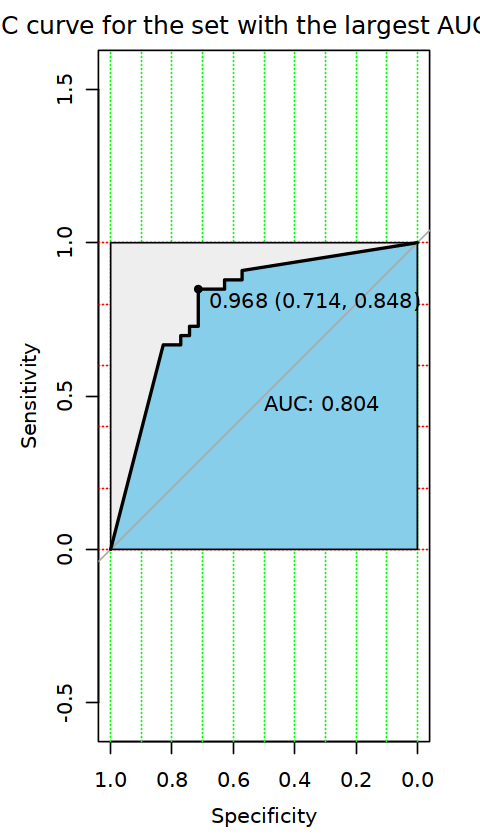

In [246]:
roc_curve <- pROC::roc(as.numeric(fold_test$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="ROC curve for the set with the largest AUC value")

In [247]:
library(ROCR)

dd<-datadist(data)  #开始打包数据
options(datadist="dd")

data$Group = as.factor(data$Group)

fit1 <- lrm(Group~AC132872.2+NEK2+CCNA2+SAP130 , data=data,x=T,y=T)


fit1

#  https://blog.csdn.net/Ayue0616/article/details/126601832

# cal1 <- calibrate(fit1, method='boot', B=1000) 
# plot(cal1,xlim=c(0,1.0),ylim=c(0,1.0))

### https://blog.51cto.com/u_15172991/5428282  模型图的解释参考链接

# https://ayueme.github.io/R_clinical_model/nomogram-essential.html

# https://blog.csdn.net/Dr_long1996/article/details/135446784

save(fit1,data,file = 'train.fit1.rda')

#列线图代码只能在Rstudio话

# library('regplot')
# regplot(fit1,
#         plots = c("violin", "boxes"), ##连续性变量形状，可选"no plot" "density" "boxes" "ecdf" "bars" "boxplot" "violin" "bean" "spikes"；分类变量的形状，可选"no plot" "boxes" "bars" "spikes"
#         observation = data[1,], #用哪行观测，或者T F
#         center = T, # 对齐变量
#         subticks = T,
#         droplines = T,#是否画竖线
#         title = "nomogram",
#         points = T, # 截距项显示为0-100
#         odds = T, # 是否显示OR值
#         showP = T, # 是否显示变量的显著性标记
#         rank = "sd", # 根据sd给变量排序
#         interval="confidence", # 展示可信区间
#         clickable = F # 是否可以交互
# )

Logistic Regression Model

lrm(formula = Group ~ AC132872.2 + NEK2 + CCNA2 + SAP130, data = data, 
    x = T, y = T)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs            85    LR chi2      59.37     R2       0.670    C       0.927    
 1             43    d.f.             4     R2(4,85) 0.479    Dxy     0.854    
 0             42    Pr(> chi2) <0.0001    R2(4,63.7)0.581    gamma   0.855    
max |deriv| 7e-08                           Brier    0.115    tau-a   0.432    

           Coef     S.E.   Wald Z Pr(>|Z|)
Intercept   15.0083 3.4430  4.36  <0.0001 
AC132872.2  -4.0132 1.4002 -2.87  0.0042  
NEK2       -13.5900 6.0391 -2.25  0.0244  
CCNA2       -2.6275 0.9592 -2.74  0.0062  
SAP130      -0.5966 0.1819 -3.28  0.0010  


In [253]:
fit.reduce <- glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=data,family=binomial())

In [254]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example.csv",
          quote = F,row.names = F)


Waiting for profiling to be done...



In [293]:
df5

,Var,OR,Pvalue,OR_1,OR_2,OR_mean
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AC132872.2,AC132872.2,-4.01(-7.18~-1.59),0.004,-7.1788921,-1.5913535,-4.0131795
NEK2,NEK2,-13.59(-26.72~-2.64),0.024,-26.7179089,-2.6406154,-13.5899731
CCNA2,CCNA2,-2.63(-4.71~-0.92),0.006,-4.7092999,-0.9221778,-2.6275058
SAP130,SAP130,-0.6(-1~-0.27),0.001,-0.9963749,-0.2713556,-0.5965813


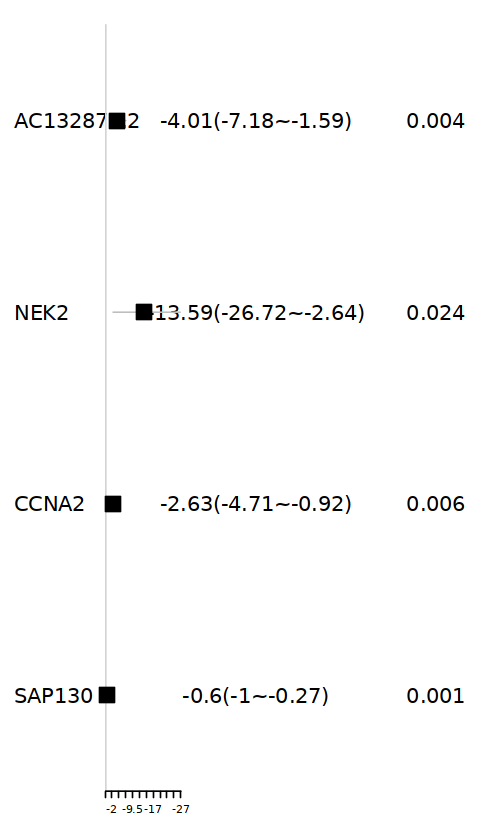

In [255]:

library(forestplot)
fp<-read.csv("forestplot_example.csv",header=T)

forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           graph.pos=2)

In [146]:
library("autoReg")


Attaching package: 'autoReg'


The following object is masked from 'package:MASS':

    select




In [250]:
expr5 =expr4

In [251]:
overall.log =  glm(Group~.,data=expr5,family=binomial())

In [252]:
model3<-autoReg(overall.log,uni=TRUE,milti=TRUE,threshold=0.05)

In [253]:
model3

name,desc,0 (N=18),1 (N=16),id,OR (univariable),OR (multivariable)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CCDC147,Mean <U+00B1> SD,1.0 <U+00B1> 0.3,1.3 <U+00B1> 0.6,CCDC147,"9.62 (1.14-81.27, p=.038)","116.74 (1.10-12427.34, p=.046)"
SAP130,Mean <U+00B1> SD,11.0 <U+00B1> 1.3,12.9 <U+00B1> 1.8,SAP130,"2.45 (1.30-4.62, p=.005)","5.91 (1.25-28.03, p=.025)"
HIST2H2BE,Mean <U+00B1> SD,21.2 <U+00B1> 4.7,33.3 <U+00B1> 11.0,HIST2H2BE,"1.24 (1.06-1.44, p=.006)","1.27 (0.97-1.65, p=.081)"
IL10RB,Mean <U+00B1> SD,31.8 <U+00B1> 4.6,36.9 <U+00B1> 5.7,IL10RB,"1.22 (1.03-1.44, p=.018)","0.88 (0.64-1.22, p=.445)"


In [ ]:
# forestplot(labeltext=as.matrix(fp[,1:3]),
#            mean=fp$OR_mean,
#            lower=fp$OR_1,
#            upper=fp$OR_2,
#            zero=0,
#            boxsize=0.2,
#            lineheight = unit(7,'mm'),
#            colgap=unit(2,'mm'),
#            lwd.zero=1.5,
#            lwd.ci=2, 
#            col=fpColors(box='#458B00',
#                         summary='#8B008B',
#                         lines = 'black',
#                         zero = '#7AC5CD'),
#            xlab="OR",
#            lwd.xaxis =1,
#            txt_gp = fpTxtGp(ticks = gpar(cex = 0.85),
#                             xlab  = gpar(cex = 0.8),
#                             cex = 0.9),
#            lty.ci = "solid",
#            title = "Forestplot", 
#            line.margin = 0.08,
#            graph.pos=2)


In [ ]:
#nmfinput= data[MDD,c('MYRF','IGHJ3P','RBMS1P1','CTD.2114J12.1')] %>%  t() %>%  as.data.frame()

In [ ]:
library(NMF)

In [ ]:
ranks <- 1:10
estim.coad <- nmf(nmfinput,ranks, nrun=10)
duplicated(colnames(nmfinput))

In [ ]:
plot(estim.coad)

In [ ]:
seed = 2020820
nmf.rank4 <- nmf(nmfinput, 
                 rank = 2, 
                 nrun=50,
                 seed = seed, 
                 method = "brunet")

In [ ]:
jco <- c("#EABF00","#C6524A","#868686")
index <- extractFeatures(nmf.rank4,"max") 
sig.order <- unlist(index)
NMF.Exp.rank4 <- nmfinput[sig.order,]
NMF.Exp.rank4 <- na.omit(NMF.Exp.rank4) #sig.order有时候会有缺失值
group <- predict(nmf.rank4) # 提出亚型
table(group)
consensusmap(nmf.rank4,
             labRow = NA,
             labCol = NA,
             annCol = data.frame("cluster"=group[colnames(NMF.Exp.rank4)]),
             annColors = list(cluster=c("1"=jco[1],"2"=jco[2])))

In [ ]:
library(tinyarray)

In [ ]:
data1 = data[MDD,-1] %>%  t() %>% as.data.frame()

In [ ]:
a = data1[,colnames(nmfinput)]

In [ ]:
cg=names(tail(sort(apply(a,1,sd)),12000))
n=a[cg,]

In [ ]:
draw_pca(n,group)

In [ ]:
library(Rtsne)
tsne_out = Rtsne(t(n),perplexity = 1)
pdat = data.frame(tsne_out$Y,factor(group))
colnames(pdat) = c("Y1","Y2","group")
head(pdat)

In [ ]:
pdat1 = pdat %>% tibble::rownames_to_column(.,'sample')

In [ ]:
bulk2.group = pdat1[,c(1,4)]
write.csv(bulk2.group,file = 'bulk2.group.csv',row.names =F)

In [ ]:
dim(bulk2.group)

In [ ]:
library(ggplot2)
library(paletteer)
ggplot(pdat,aes(Y1,Y2))+
  geom_point(aes(Y1,Y2,fill = group),shape = 21,color = "black")+
  stat_ellipse(aes(color = group,fill = group),
               geom = "polygon",
               alpha = 0.3,
               linetype = 2)+
  scale_color_paletteer_d("RColorBrewer::Set2")+
  scale_fill_paletteer_d("RColorBrewer::Set2")+
  theme_classic()+
  theme(legend.position = "top")